# Croma

El efecto [croma](https://es.wikipedia.org/wiki/Croma) permite sustituir los píxeles de una imagen que tienen un tono de color determinado (usualmente verde o azul). Para la identificación de los píxeles que tienen un tono determinado es de especial utilidad emplear el espacio de color [HSV](https://es.wikipedia.org/wiki/Modelo_de_color_HSV) pues el tono se encuentra en una sola de las componentes mientras que las otras dos indican la intensidad y el brillo con que es percibido dicho tono.

In [1]:
import cv2
import numpy as np
import cuia
from matplotlib import pyplot as plt

Para empezar debemos identificar el tono que queremos sustituir en el espacio de color HSV.

**Nota:** No hay que olvidar que, aunque el modelo de color establece valores de H entre 0 y 360, OpenCV los escala al rango [0,180).

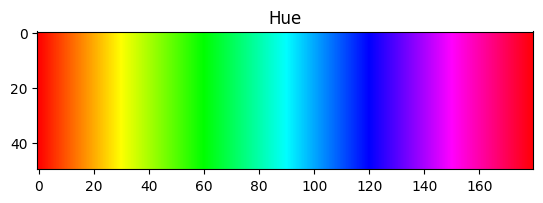

In [2]:
mapa = np.full((50,180,3), 255, dtype=np.uint8)
for i in range(180):
    mapa[:,i,0] = i
mapabgr = cv2.cvtColor(mapa, cv2.COLOR_HSV2RGB)

fig = plt.figure()
plt.title("Hue")
plt.imshow(mapabgr)


In [3]:
croma = cv2.imread("media/croma.jpg")

Analizaremos la siguiente imagen para tratar de identificar y sustituir el fondo. Usaremos [calcHist](https://docs.opencv.org/4.x/d6/dc7/group__imgproc__hist.html#ga4b2b5fd75503ff9e6844cc4dcdaed35d) para calcular el [histograma](https://es.wikipedia.org/wiki/Histograma) de los tonos para representarlo mediante Matplotlib.

![croma](media/croma.jpg "croma")

Crearé una función para cálculo de histogramas que guardaré en cuia.py

In [9]:
def histogramahsv(imagen, solotono=True):
    if solotono:
        hist, (ax1) = plt.subplots(1)
    else:
        hist, (ax1, ax2, ax3) = plt.subplots(1,3)
    framehsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(framehsv)
    histoh = cv2.calcHist( [framehsv], [0], None, [180], [0, 180])
    ax1.set_title("Hue")
    ax1.get_yaxis().set_visible(False)
    ax1.plot(histoh)
    if not solotono:
        histos = cv2.calcHist( [framehsv], [1], None, [256], [0, 256])
        ax2.set_title("Sat")
        ax2.get_yaxis().set_visible(False)
        ax2.plot(histos)
        histov = cv2.calcHist( [framehsv], [2], None, [256], [0, 256])
        ax3.set_title("Val")
        ax3.get_yaxis().set_visible(False)
        ax3.plot(histov)
    plt.show()

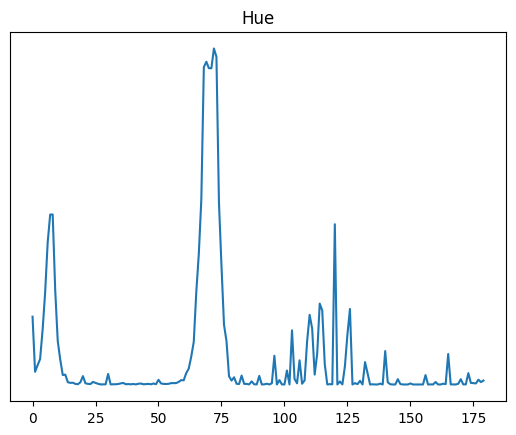

In [10]:
histogramahsv(croma)

Podemos comprobar como el tono predominante en el conjunto de píxeles está alrededor de 70 (en la escala [0,180) de OpenCV, que en la escala oficial de HSV [0,360) sería 140.

En todo caso podemos calcular el histograma de una parte de la imagen que sea representativa del color que queremos eliminar.

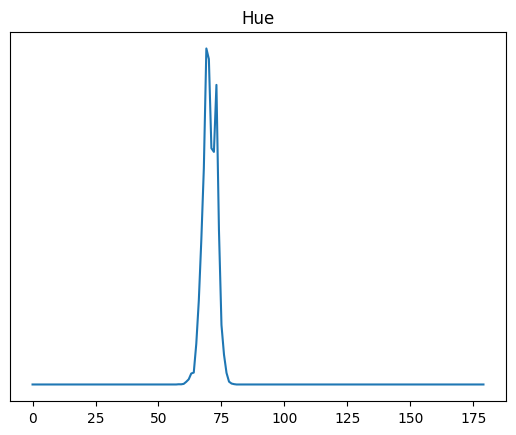

In [11]:
histogramahsv(croma[0:200, 0:200, :]) #Cálculo del histograma de tono del recuadro de 200x200 superior izquierdo

Si observamos la saturación y valor de la zona podemos comprobar que, al ser la iluminación homogénea también es fácil acotar los valores de S y V, aunque esto no será tan necesario (la imagen no tiene una iluminación buena por lo que los resultados no serán tan buenos como podría desearse). Sí que debemos tener en cuenta que valores bajos de saturación y valor conducen a imágenes demasiado oscuras en las que es defícil distinguir el tono. En este ejemplo podemos comprobar que tanto saturación como valor se encuentran por encima de 95.

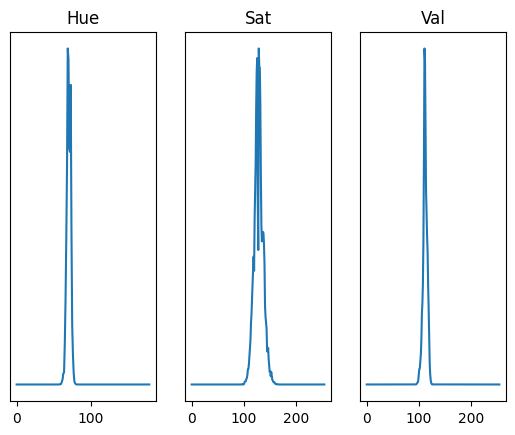

In [12]:
histogramahsv(croma[0:200, 0:200, :], solotono=False)

Aprovecharemos la función [inrange](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981) vista anterior mente para identificar todos los píxeles cuyo tono se encuentre en [55,85], saturación por encima de 50 hasta 255 (no importa excedernos por encima ya que eso nos llevará a tonos más reconocibles).

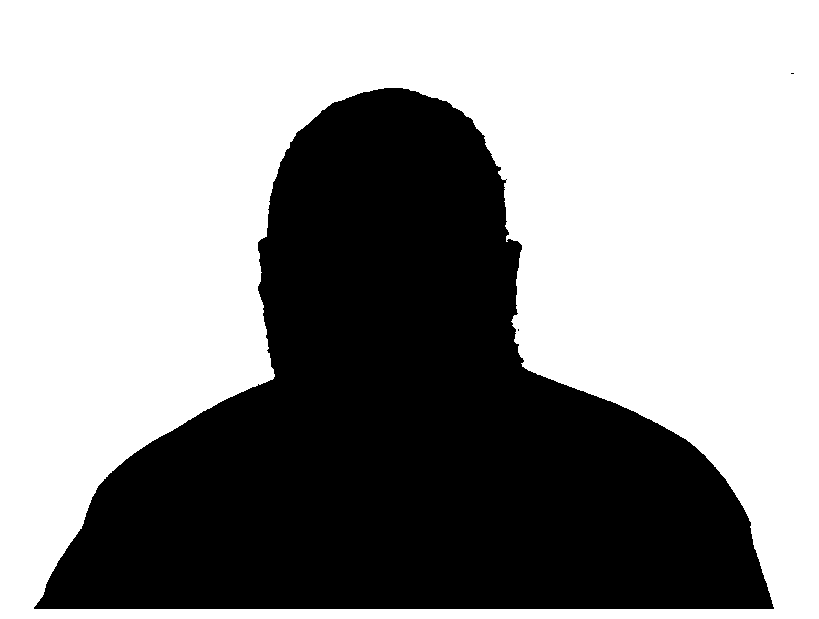

In [32]:
cromahsv = cv2.cvtColor(croma, cv2.COLOR_BGR2HSV) #Convertimos la imagen al espacio de color HSV
m = cv2.inRange(cromahsv, (55,50,50), (85,255,255))
cuia.plot(m)

Usando operaciones a nivel de bit podemos aislar el primer plano.

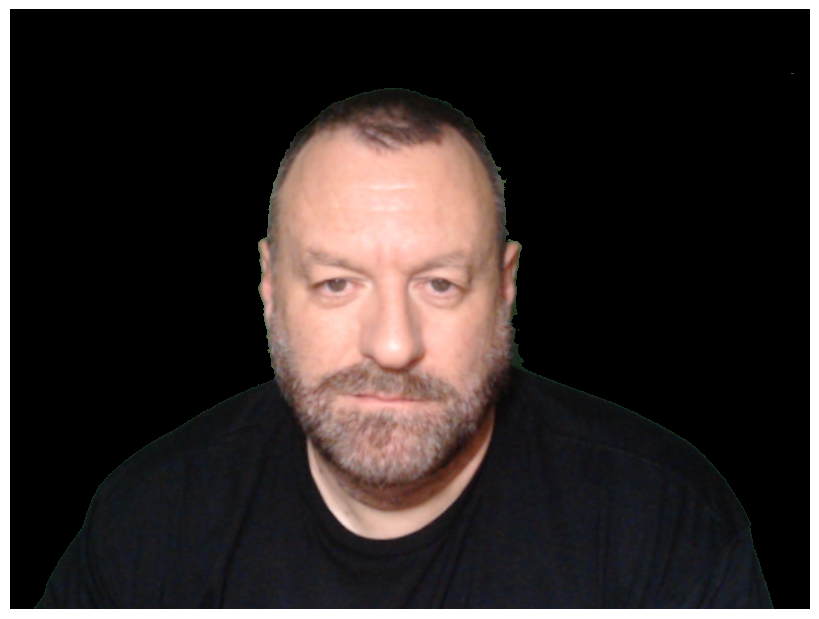

In [33]:
mascarafondo = np.stack((m,m,m), axis=2) # Hacemos la máscara de 3 bandas para poder operar
mascaraprimerplano = cv2.bitwise_not(mascarafondo) # La inversa identifica a los píxeles de primer plano
primerplano = cv2.bitwise_and(croma, mascaraprimerplano)
cuia.plot(primerplano)

Para terminar usaré una imagen de las mismas dimensiones para aplicarle la máscara de fondo.

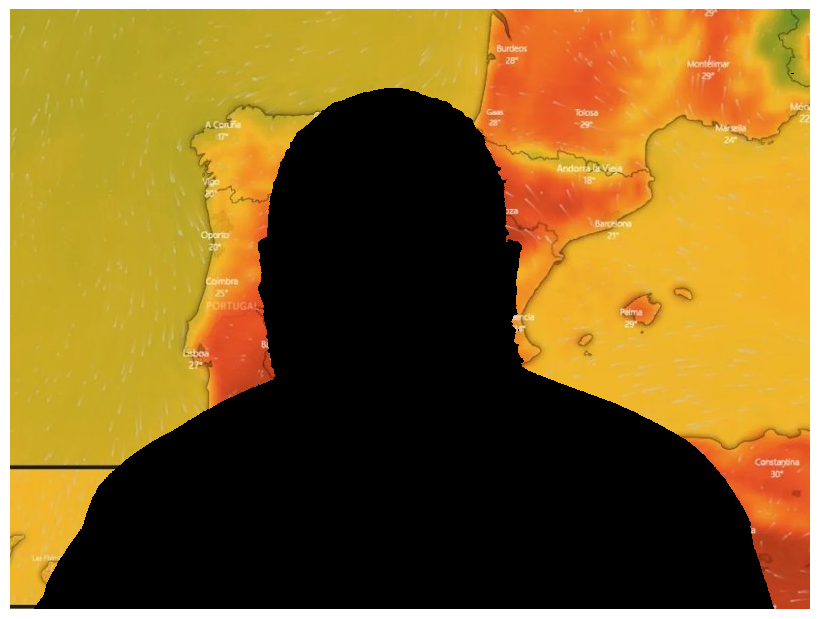

In [34]:
mapa = cv2.imread("media/mapa.jpg")
fondo = cv2.bitwise_and(mapa, mascarafondo)
cuia.plot(fondo)

Lan solo falta combinar con OR las imágenes de fondo y primer plano

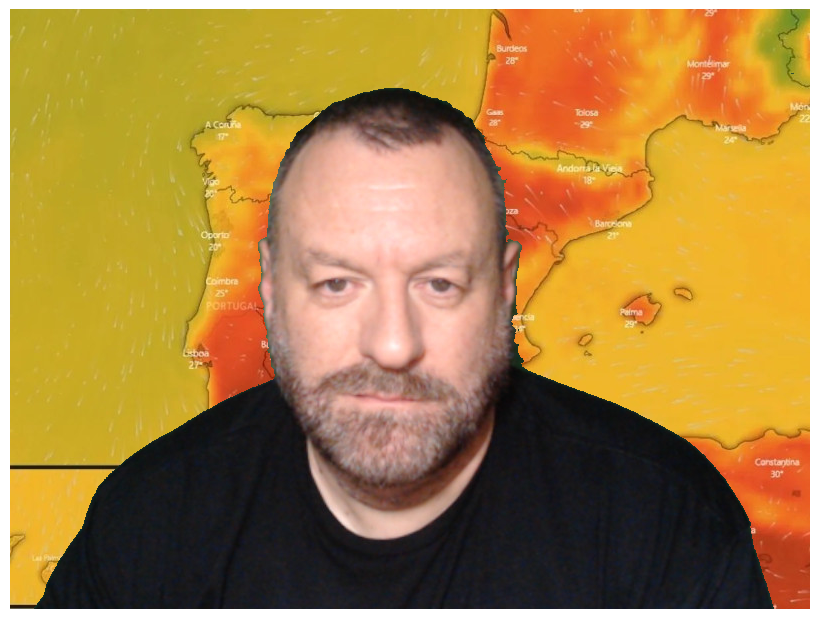

In [35]:
res = cv2.bitwise_or(fondo, primerplano)
cuia.plot(res)

Los dientes de sierra de la imagen final se deben a que la iluminación no es la idónea. De todos modos suele aplicarse un desenfoque gaussiano a la máscara antes de aplicarla.